In [9]:
import pyaudio
import wave
import sys
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import wave


In [10]:
FORMAT = pyaudio.paInt16
CHANNELS = 1  
RATE = 44100 if sys.platform == 'darwin' else 16000  
CHUNK = 1024  # Buffer size for audio chunks

In [11]:
# Initialize PyAudio and start the stream
def start_audio_stream():
    audio = pyaudio.PyAudio()
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)
    return audio, stream

In [12]:

def compute_energy(data):
    energy=10*math.log(sum(sample**2 for sample in data))
    return energy

In [13]:
# Capture audio until silence is detected
import struct
def capture_audio(stream):
    print("Hit Enter to start recording")
    input()
    print("Recording in progress...")
    frames = []
    silence_threshold = 200  # ambient noise
    silence_duration = 1 # Duration of silence in seconds to stop recording
    silence_time = 0

    while True:
        data = stream.read(CHUNK, exception_on_overflow=False)
        frames.append(data)

# Unpack short integers from the binary data and collect in `data_fl`
        
        data_fl = [struct.unpack('h', data[i:i+2])[0] for i in range(0, len(data), 2)]
        
        # Check the volume of the input
        rms = compute_energy(data_fl)
        
        # If the input volume is below the threshold, we consider it silence
        if rms < silence_threshold:
            if silence_time == 0:
                silence_time = time.time()  # Mark the start of silence
            elif time.time() - silence_time > silence_duration:
                break  # Stop recording after silence_duration seconds of silence
        else:
            silence_time = 0  # Reset silence timer if noise is detected

    return frames

In [14]:
# Save captured audio to a file
def save_audio(frames, filename):
    wave_file = wave.open(filename, 'wb')
    wave_file.setnchannels(CHANNELS)
    wave_file.setsampwidth(pyaudio.get_sample_size(FORMAT))
    wave_file.setframerate(RATE)
    wave_file.writeframes(b''.join(frames))
    wave_file.close()

In [15]:
# Handle the audio capture process
def main():
    audio, stream = start_audio_stream()
    frames = capture_audio(stream)

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # Save the recorded frames as a WAV file
    filename = 'captured_speech.wav'
    save_audio(frames, filename)
    print(f"Recording stopped and saved to '{filename}'")

if __name__ == '__main__':
    main()
    

Hit Enter to start recording
Recording in progress...
Recording stopped and saved to 'captured_speech.wav'


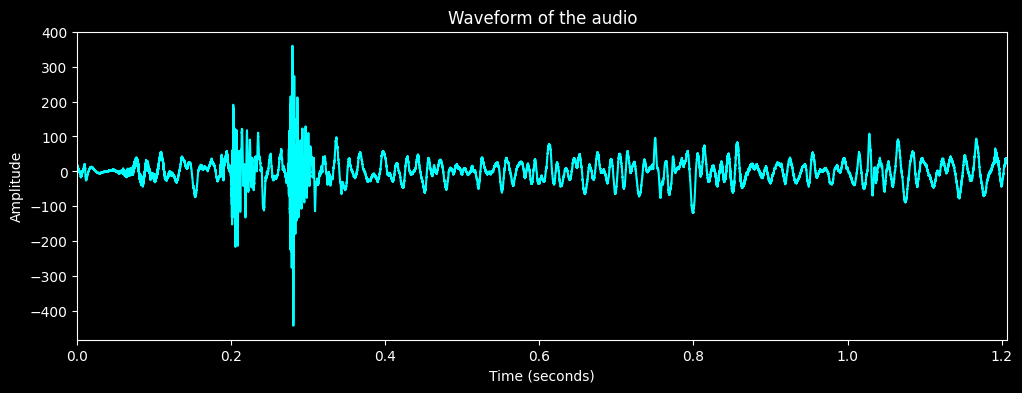

In [16]:

def plot_waveform(filename):
    
    with wave.open(filename, 'rb') as wave_file:
        # Extract Raw Audio 
        signal = wave_file.readframes(-1)
        # Convert binary data to integers
        signal = np.frombuffer(signal, dtype='int16')
        
        # Get the frame rate
        framerate = wave_file.getframerate()
        
        # Time axis in seconds
        time = np.linspace(0, len(signal) / framerate, num=len(signal))

        plt.style.use('dark_background')  # Set the background theme
        
        # Plotting the waveform
        plt.figure(figsize=(12, 4))
        plt.plot(time, signal, color='cyan')
        plt.title('Waveform of the audio')
        plt.ylabel('Amplitude')
        plt.xlabel('Time (seconds)')
        plt.xlim(left=time[0], right=time[-1])
        plt.show()

plot_waveform('captured_speech.wav')
